In [18]:
# install the neccessary libraries 
!pip install torch
!pip install matplotlib 
!pip install tqdm 
!pip install scikit-learn

In [19]:
import torch # core Pytorch functionalities
import torch.nn as nn # implements neural network layers and loss functions 
import torch.nn.functional as F # provide functions
import torch.optim as optim  # contains optimization algorithms (not used in the sample)

In [20]:
# the variable `corpus` holds a large block of text, serves as the dataset for the model 
# it will be processed later to generate the training dataset 

corpus = """
From Wikipedia, the free encyclopedia

Example of a single industrial control loop; showing continuously modulated control of process flow.
A closed-loop controller or feedback controller is a control loop which incorporates feedback, in contrast to an open-loop controller or non-feedback controller. A closed-loop controller uses feedback to control states or outputs of a dynamical system. Its name comes from the information path in the system: process inputs (e.g., voltage applied to an electric motor) have an effect on the process outputs (e.g., speed or torque of the motor), which is measured with sensors and processed by the controller; the result (the control signal) is "fed back" as input to the process, closing the loop.[1]

In the case of linear feedback systems, a control loop including sensors, control algorithms, and actuators is arranged in an attempt to regulate a variable at a setpoint (SP). An everyday example is the cruise control on a road vehicle; where external influences such as hills would cause speed changes, and the driver has the ability to alter the desired set speed. The PID algorithm in the controller restores the actual speed to the desired speed in an optimum way, with minimal delay or overshoot, by controlling the power output of the vehicle's engine. Control systems that include some sensing of the results they are trying to achieve are making use of feedback and can adapt to varying circumstances to some extent. Open-loop control systems do not make use of feedback, and run only in pre-arranged ways.

Closed-loop controllers have the following advantages over open-loop controllers:

disturbance rejection (such as hills in the cruise control example above)
guaranteed performance even with model uncertainties, when the model structure does not match perfectly the real process and the model parameters are not exact
unstable processes can be stabilized
reduced sensitivity to parameter variations
improved reference tracking performance
improved rectification of random fluctuations[2]
In some systems, closed-loop and open-loop control are used simultaneously. In such systems, the open-loop control is termed feedforward and serves to further improve reference tracking performance.

A common closed-loop controller architecture is the PID controller.


A basic feedback loop
Open-loop and closed-loop
This section is an excerpt from Control loop § Open-loop and closed-loop.[edit]
Fundamentally, there are two types of control loop: open-loop control (feedforward), and closed-loop control (feedback).


An electromechanical timer, normally used for open-loop control based purely on a timing sequence, with no feedback from the process
In open-loop control, the control action from the controller is independent of the "process output" (or "controlled process variable"). A good example of this is a central heating boiler controlled only by a timer, so that heat is applied for a constant time, regardless of the temperature of the building. The control action is the switching on/off of the boiler, but the controlled variable should be the building temperature, but is not because this is open-loop control of the boiler, which does not give closed-loop control of the temperature.

In closed loop control, the control action from the controller is dependent on the process output. In the case of the boiler analogy this would include a thermostat to monitor the building temperature, and thereby feed back a signal to ensure the controller maintains the building at the temperature set on the thermostat. A closed loop controller therefore has a feedback loop which ensures the controller exerts a control action to give a process output the same as the "reference input" or "set point". For this reason, closed loop controllers are also called feedback controllers.[3]

The definition of a closed loop control system according to the British Standards Institution is "a control system possessing monitoring feedback, the deviation signal formed as a result of this feedback being used to control the action of a final control element in such a way as to tend to reduce the deviation to zero."[4]

Likewise; "A Feedback Control System is a system which tends to maintain a prescribed relationship of one system variable to another by comparing functions of these variables and using the difference as a means of control."[5]
Closed-loop transfer function
Main article: Closed-loop transfer function
The output of the system y(t) is fed back through a sensor measurement F to a comparison with the reference value r(t). The controller C then takes the error e (difference) between the reference and the output to change the inputs u to the system under control P. This is shown in the figure. This kind of controller is a closed-loop controller or feedback controller.

This is called a single-input-single-output (SISO) control system; MIMO (i.e., Multi-Input-Multi-Output) systems, with more than one input/output, are common. In such cases variables are represented through vectors instead of simple scalar values. For some distributed parameter systems the vectors may be infinite-dimensional (typically functions).

A simple feedback control loop
If we assume the controller C, the plant P, and the sensor F are linear and time-invariant (i.e., elements of their transfer function C(s), P(s), and F(s) do not depend on time), the systems above can be analysed using the Laplace transform on the variables. This gives the following relations:

PID feedback control
Main article: PID controller

A block diagram of a PID controller in a feedback loop, r(t) is the desired process value or "set point", and y(t) is the measured process value.
A proportional–integral–derivative controller (PID controller) is a control loop feedback mechanism control technique widely used in control systems.

A PID controller continuously calculates an error value e(t) as the difference between a desired setpoint and a measured process variable and applies a correction based on proportional, integral, and derivative terms. PID is an initialism for Proportional-Integral-Derivative, referring to the three terms operating on the error signal to produce a control signal.

The theoretical understanding and application dates from the 1920s, and they are implemented in nearly all analogue control systems; originally in mechanical controllers, and then using discrete electronics and later in industrial process computers. The PID controller is probably the most-used feedback control design.

If u(t) is the control signal sent to the system, y(t) is the measured output and r(t) is the desired output, and e(t) = r(t) − y(t) is the tracking error, a PID controller has the general form

However, in practice, a pure differentiator is neither physically realizable nor desirable[6] due to amplification of noise and resonant modes in the system. Therefore, a phase-lead compensator type approach or a differentiator with low-pass roll-off are used instead.
"""

In [21]:
# TEXT PREPROCESSING STEP
import re 
import random 

def create_dataset(corpus:str, window=2):
    # convert text to lower case
    corpus = corpus.lower()

    # remove any characters that aren't letters or spaces, keeping only alphabetic text
    # and then split text into individual words 
    corpus = re.sub(r'[^a-z\s]', '', corpus).split()

    # set(corpus) > convert the list of words (from the corpus) into a set (automatically removes any duplicate words, leaving only unique words) - creating a 'vocabulary'
    # and then sort this set alphabetically 
    vocab = sorted(set(corpus))

    # print the whole set - the 'vocabulary'
    print(vocab)

    # the size of the vocabulary - the total number of unique words in the corpus 
    V = len(vocab)

    # creates a mapping from each word to an unique index
    word_to_idx = {w: i for i, w in enumerate(vocab)}

    # create a reverse mapping from indexes back to words
    idx_to_word = {i: w for i, w in enumerate(vocab)}

    # initialize a list for 'positive' training examples (word-context pairs)
    data_pos = []

    # `window` (=2) > size of the context window, the loop starts at index `window`
    # `len(corpus)` > the total number of words in the corpus (split text into individual words)
    # `len(corpus> - window - 1` > the loop stops before reaching the end of the corpus 
    # starts at i = window and ends just before i = len(corpus> - window - 1 > ensures that the target word always has a context window of `window` on both sides 
    for i in range(window, len(corpus) - window - 1):
        # extracts a "context window" of words around the target word at index i 
        # context is a list 
        context = corpus[i - window : i + window + 1]

        # delete the middle word (which is the target word itself)
        del context[window]

        # assign the current target word to the variable `target`
        target = corpus[i]

        # creates positive training examples for the target word by pairing the target word with each word in the context, and appends these pairs to the `data_pos` list 
        # for each word `c` in the `context`, it creates a tuple `(target, c, 1)` and add it to `data_pos`
        # the `1` indicates that this is a positive example (the words actually co-occur in the text) 
        data_pos += [(target, c, 1) for c in context]

    # create a list for negative examples (unrelated word pairs) 
    data_neg = []

    # convert the vocabulary (which was originally a set) into a list, to access to elements by index 
    vocab_list = list(vocab)

    # loops over every word `w` in `vocab_list`
    for w in vocab_list:
        # repeats `2 * window` times for each word `w` > ex: 2 words before and 2 words after the target word 
        for _ in range(2 * window):
            # pick a random index between `0` and `V-1`
            # this index `idx` will be used to randomly select a word from the vocabulary list to act as a negative sample 
            # negative sampling helps the model learn which words DO NOT occur, alongside those that do (positive samples)
            idx = random.randint(0, V - 1)

            # use the random index from the line above to select a random word from the vocab_list
            neg_sample = vocab_list[idx]

            # adds a negative sample to the `data_neg` list 
            # each entry is a tuple (the current word from vocab_list, the random chosen word from the vocabulary, 0 - indicates that this is a negative example)
            data_neg.append((w, neg_sample, 0))
    
    # combines the positive examples and the negative examples into a single list called `data` 
    data = data_pos + data_neg

    # randomly shuffles the combined dataset 
    random.shuffle(data)

    # vocab: the list of unique wordss 
    # data: the final dataset 
    # word_to_idx: the dictionary that maps each word to its corresponding index in the vocabulary 
    # idx_to_word: the dictionary that maps each index back to its corresponding words
    return vocab, data, word_to_idx, idx_to_word

In [22]:
# calls the create_dataset function 
# the 4 variables `vocab`, `data`, `word_to_idx` and `idx_to`word` are going to store the results returned by the function
vocab, data, word_to_idx, idx_to_word = create_dataset(corpus=corpus)

['a', 'ability', 'above', 'according', 'achieve', 'action', 'actual', 'actuators', 'adapt', 'advantages', 'algorithm', 'algorithms', 'all', 'also', 'alter', 'amplification', 'an', 'analogue', 'analogy', 'analysed', 'and', 'another', 'application', 'applied', 'applies', 'approach', 'architecture', 'are', 'arranged', 'article', 'as', 'assume', 'at', 'attempt', 'back', 'based', 'basic', 'be', 'because', 'being', 'between', 'block', 'boiler', 'british', 'building', 'but', 'by', 'c', 'calculates', 'called', 'can', 'case', 'cases', 'cause', 'central', 'change', 'changes', 'circumstances', 'closed', 'closedloop', 'closedloopedit', 'closing', 'comes', 'common', 'comparing', 'comparison', 'compensator', 'computers', 'constant', 'continuously', 'contrast', 'control', 'controlled', 'controller', 'controllers', 'controlling', 'correction', 'cruise', 'cs', 'dates', 'definition', 'delay', 'depend', 'dependent', 'derivative', 'design', 'desirable', 'desired', 'deviation', 'diagram', 'difference', 'di

In [31]:
# V: vocab size
# d: dimension of the embedding
# w: V x d
# c: V x d
# Find w, c such that the loss is minimized
# Loss: BCE Loss

import matplotlib.pyplot as plt # used for plotting graphs, specifically to visualize the loss over time 
import tqdm # provides a progress bar for loops, which is helpful to track the training process 

# this function trains a word embedding model using a technique similar to Word2Vec
# the goal of the process is to learn word embeddings (vector representations) for each word in the vocabulary by minimizing a loss function (Binary Cross-Entropy Loss)
# `w` is a matrix representing the word embeddings for the target word (V - number of words x d - the embedding dimension)
# `c` is a matrix representing word embeddings for the context words (V x d)
# `data` is the dataset cnosisting of both positive and negative examples 
# `lr` is the learning rate, which controls how big the steps are when updating the model parameters during training 
# `n_epochs` is the number of timesto go through the entire dataset during training (the number of training cycles)
def train(w, c, data, lr, n_epochs=10):

    # define the loss function
    lossf = nn.BCELoss()

    # initializes and empty list to store the losst values at each training step, which will later be used for plotting 
    losses = []

    # print(f"Data length: {len(data)}")  # This should print the number of data points
    # print(f"Example data point: {data[0]}")  # Check the structure of the first element

    # this is the nested training loop   
    # the outer loop runs for a specified number of epochs (each epoch means the model goes through the entire dataset once) 
    # `tqdm.trange(n_epochs)` is just a tool to show a progress bar  
    for ei in tqdm.trange(n_epochs):
        # inner loop for training examples 
        # this loop iterates over each word pair in the `data` (both positive and negative)
        # `di` is one data point, a tuple in the form (target_word, context_word, label - 1 or 0)
        for di in data:
            if di[0] not in word_to_idx or di[1] not in word_to_idx:
                print(f"Word not found in vocabulary: {di[0]} or {di[1]}")
                break  # Stop execution if there's an issue

            # we need the numerical index for the words to find their corresponding embeddings (vector) in the `w` and `c` matrices
            # look up the index of the target word in the vocabulary 
            i = word_to_idx[di[0]]
            j = word_to_idx[di[1]]

            # we need to compare the 2 embeddings to check how similar they are, which tells the model if they should be close together or not in the embedding space 
            # extract the word embedding (vector) for the target word from the `w` matrix 
            wi = w[i, :]
            # extract the word embedding for the context word from the `c` matrix 
            cj = c[j, :]

            # reshape the word vectors into column vectos and mark them for gradient calculation 
            # the vectors need to be in the right format (column vectors) for matrix multiplication
            wi = wi.reshape(-1, 1).requires_grad_()
            cj = cj.reshape(-1, 1).requires_grad_()

            # calculate the predicted similarity `pij` between target word and context word > similarity score  
            # passing the result through sigmoid function (converts the score to a probability between 0 and 1)
            pij = F.sigmoid(wi.T @ cj)

            # calculte the loss using Binary Cross-Entropy 
            loss = lossf(pij, torch.FloatTensor([[di[2]]]))

            # adds the current loss value to the `losses` list > the loss should decrease as training progresses 
            losses.append(loss.item())

            # performs backpropagation > calculates how much the word embeddings should change to reduce the loss 
            # it computes the gradients for each parameter 
            loss.backward()

            # udpate parameters
            # this line updates the word embeddings without tracking gradients
            with torch.no_grad():
                # the embeddings are adjusted by subtracting the product of the learning rate and their gradients
                wi = wi - lr * wi.grad
                cj = cj - lr * cj.grad

            # these lines put the updated word embeddings back into their original positions in the `w` and `c` matrices
            w[i, :] = wi.squeeze()
            c[j, :] = cj.squeeze()
    
    # plot the losses > it should reduce overtime 
    plt.plot(losses)

    return w, c

Data length: 5792
Example data point: ('desired', 'setpoint', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


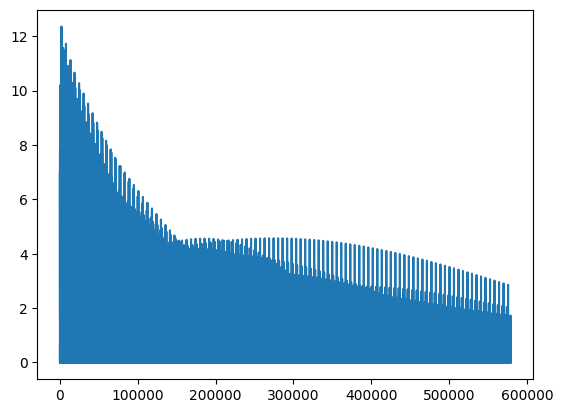

In [36]:
# `d` is the dimension of the word embeddings (or vectors)
# each word will be represented as a vector with 10 dimensions 
d = 10

# set the number of training epochs
# here, the model will go through the dataset 100 times 
n_epochs = 100

# learning rate is a small value that determines how much the weights will be updated during trainning
lr = 1e-2

# `w` is a matrix where each row correspond to a word in the vocabulary and each column represents one of the 10 dimensions of the word embedding
# `randn` initializes the matrix with numbers from a normal distribution
# `w` contains embeddings for target words (words we want to predict)
w = torch.randn(len(vocab), d)
c = torch.randn(len(vocab), d)

# train the model 
w, c = train(w=w, c=c, data=data, lr=lr, n_epochs=n_epochs)

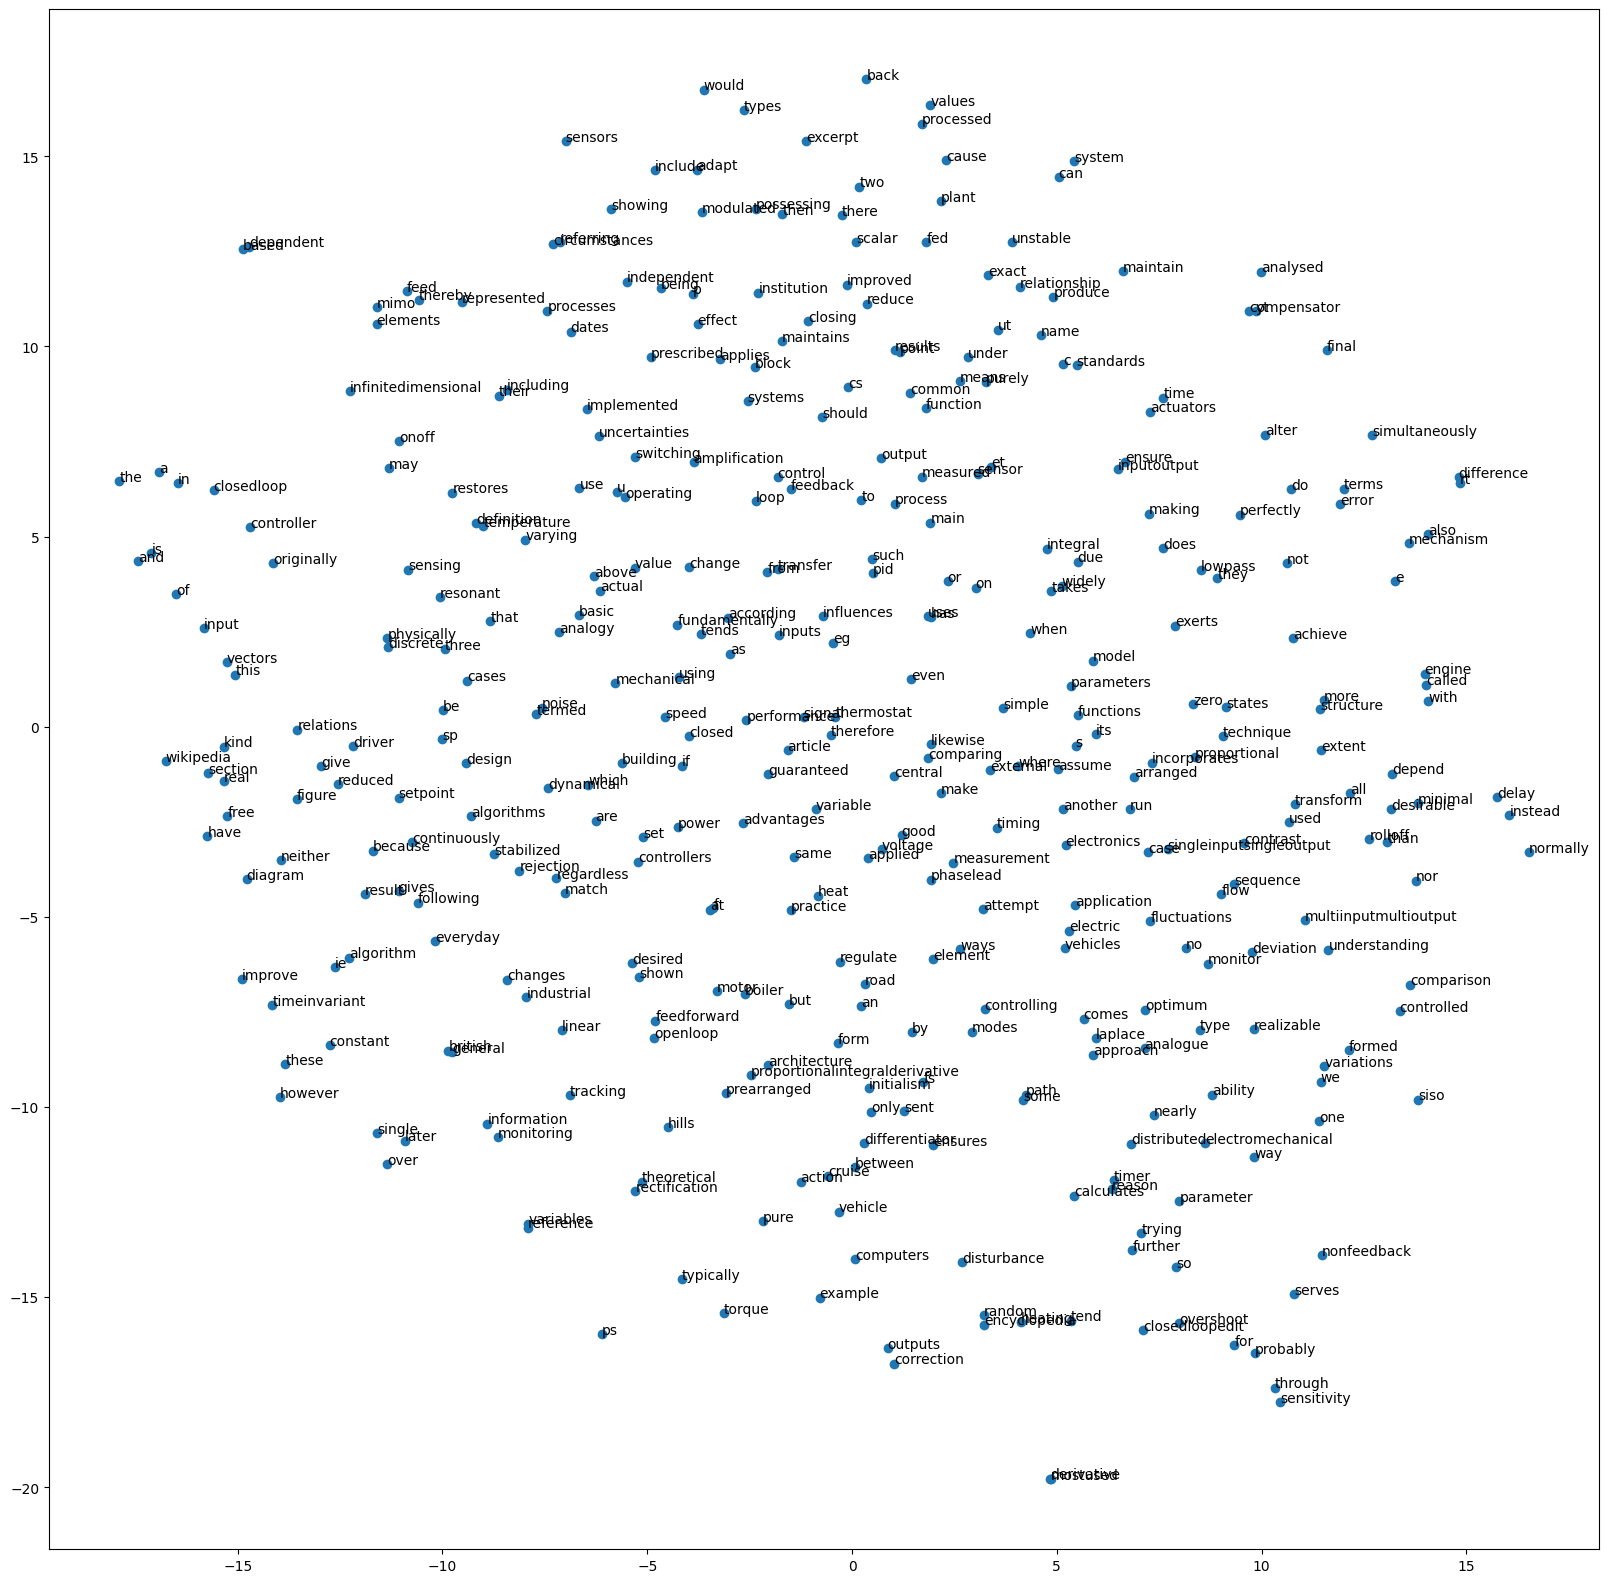

In [37]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# visualize the word vectors with t-SNE
# TSNE is a tool from the sklearn library that reduces the dimensions of high dimensionl data, so we can plot it in 2D
from sklearn.manifold import TSNE
import numpy as np # numpy helps with numerical operations and managing arrays of data 

# adds the 2 embeddings together to get a single vector representation for each word 
# the idea is that both the target word and its context contribute to the meaning of the word 
vectors = w + c 

# the embeddings are initially in a format used by PyTorch, since they were trained in PyTorch
# so here we convert them into NumPy arrays
# `detach()` is used to remove the gradients 
# `numpy()` converts the tensor (PyTorch format) to a NumPy array 
vectors = vectors.detach().numpy()

# reduce the high-dimensional vectors down to just 2 dimensions 
tsne = TSNE(n_components=2)

# applies the t_SNE algorithms to the word vectors and return the new 2D positions for each word vector 
vectors = tsne.fit_transform(vectors)

# create a large empty figure for the plot 
plt.figure(figsize=(20, 20))

# creates a scatter plot of the 2D points  
# `vectors[:, 0]` are the x-coordinates of the words 
# `vectors[:, 1]` are the y-coordinates 
plt.scatter(vectors[:, 0], vectors[:, 1])

# the loop goes through each word in the vocabulary and places a label next to its corresponding point on the scatter plot 
for i, word in enumerate(vocab):
    plt.annotate(word, (vectors[i, 0], vectors[i, 1]))

# display the plot with all the word vectors and their labels 
plt.show()